<b>Name : Dilshan J.V.A.P<br>
Index number : 190144D<br>
Assignment 2

Github: 

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import linalg
import circle_fit as cf

In [6]:
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r+n)*np.cos(t), (r+n)*np.sin(t)
X_circle = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

In [24]:
def RANSAC_Circle(data_points):
    thres = np.std(data_points)/16  # threshold for RANSAC
    num_iterations = np.log(1 - 0.95)/np.log(1 - (1 - 0.5)**3)  
    iterations_done, max_inlier_count, selected_model = 0, 0, None

    while iterations_done < num_iterations:
        iterations_done += 1
        np.random.shuffle(data_points)  # randomly selecting 3 data points
        sample_points = data_points[:3]
        print(sample_points)
        xc,yc,radius,_ = cf.least_squares_circle((sample_points)) # estimating a circle with selected data points
        center = (xc, yc)
        error = np.abs(radius - np.sqrt(np.sum((center - data_points[3:])**2, axis=1))) # computing error of remaining data points
        inliers = error <= thres # camparing the error with threshold
        inlier_count = np.count_nonzero(inliers) # number of inliers
        if inlier_count > max_inlier_count: # selecting the best model
            max_inlier_count = inlier_count
            inlier_points = []
            for index, inlier in enumerate(inliers): # filtering the inlier points
                if inlier == True:
                    inlier_points.append(data_points[3:][index])
            inlier_points = np.array(inlier_points)
            selected_model = (center, radius, sample_points, inlier_points)

    # refitting with all inliers
    xc,yc,radius,_ = cf.least_squares_circle(np.concatenate((selected_model[2], selected_model[3]), axis=0))
    best_model = ((xc, yc), radius, selected_model[2], selected_model[3])
    return best_model 

[[ 1.8432056  -8.78961001]
 [ 1.98556466 -9.93653476]
 [ 7.16550208 -5.75905092]]
[[ -2.74186901 -10.78380282]
 [ -8.3650598    6.94552306]
 [  8.45075424   2.46907474]]
[[-10.18422074   5.93021268]
 [  8.16978235  -6.86788026]
 [-10.08401422   2.45646149]]
[[-10.18422074   5.93021268]
 [  3.75263919  -9.07356972]
 [  4.42513925   9.2165867 ]]
[[ 1.98556466 -9.93653476]
 [10.08640867  0.37296773]
 [-8.31431911 -6.04563307]]
[[ 9.03848402 -2.15198542]
 [ 3.84054293 -8.82480248]
 [ 2.92459649 10.11384522]]
[[ 3.75263919 -9.07356972]
 [-4.17345951 -7.38202417]
 [-9.37076316 -0.55911011]]
[[-9.03681145  4.6626691 ]
 [ 1.8432056  -8.78961001]
 [-5.86646551  8.08161318]]
[[  2.92459649  10.11384522]
 [-10.18422074   5.93021268]
 [  6.91780176  -7.32131157]]
[[  9.03848402  -2.15198542]
 [  2.92459649  10.11384522]
 [-10.08401422   2.45646149]]
[[-7.44972732  7.22478539]
 [ 3.84054293 -8.82480248]
 [ 8.81427978 -4.43084523]]
[[ -8.17946479   5.75122845]
 [-10.0339429    3.01424599]
 [  4.4251

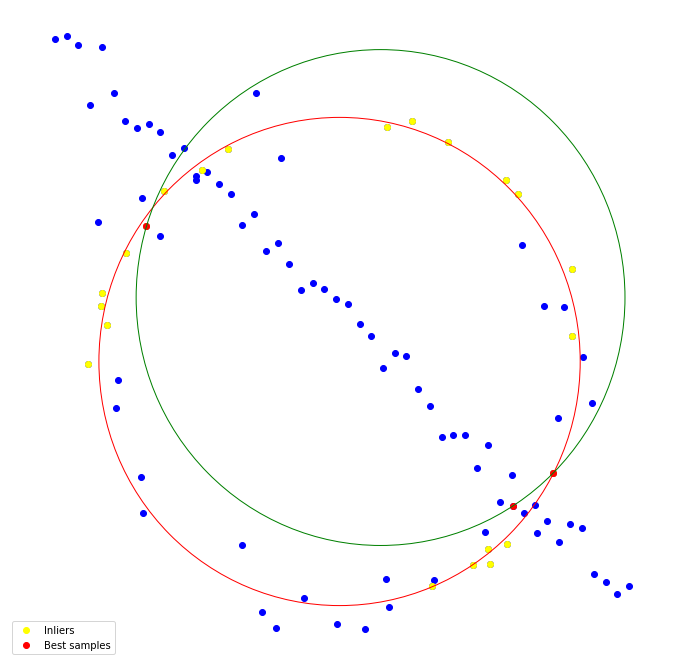

In [25]:
best_model = RANSAC_Circle(X_circle)
xc,yc,r,_ = cf.least_squares_circle(best_model[2])

figure, ax = plt.subplots(figsize=(12, 12))
RASNSAC_circle = plt.Circle(best_model[0], best_model[1], fill=False, color='red', label='RANSAC')        
ax.add_artist(RASNSAC_circle)
circle = plt.Circle((xc, yc), r, fill=False, color='green', label='Best sample')    
ax.add_artist(circle)
ax.scatter(X_circle[:, 0], X_circle[:, 1], c='blue')
ax.scatter(X_line[:, 0], X_line[:, 1], c='blue')
ax.scatter(best_model[3][:, 0], best_model[3][:, 1], c='yellow', label='Inliers')
ax.scatter(best_model[2][:, 0], best_model[2][:, 1], c='red', label='Best samples')
plt.legend(loc=3)
plt.xlim(-14, 14)
plt.axis('off')
plt.show()

In [27]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import cv2 as cv
import circle_fit as cf

        
def getCircle(pts1, pts2, pts3):
    temp = pts2[0]**2 + pts2[1]**2
    bc = (pts1[0]**2 + pts1[1]**2 - temp)/2
    cd = (temp - pts3[0]**2 - pts3[1]**2)/2
    det = (pts1[0] - pts2[0]) * (pts2[1] - pts3[1]) - (pts2[0] - pts3[0]) * (pts1[1] - pts2[1])

    if abs(det) < 1.0e-10:
        return None
    cx = (bc*(pts2[1] - pts3[1]) - cd*(pts1[1] - pts2[1]))/ det
    cy = ((pts1[0] - pts2[0]) * cd - (pts2[0] - pts3[0])*bc)/ det

    r = ((cx - pts1[0])**2 + (cy - pts1[1])**2)**0.5

    return cx, cy, r

def shortest_Dis(p,centerx,centery,radius):
    d= np.array(abs(((p[:,0]-centerx)**2+(p[:,1]-centery)**2)**0.5-radius))
    return d


def RANSAC_algo(Data,iteration,threshold,no_inlier):
    maximum=0
    output=np.array([])

    for i in range(iteration):

        np.random.shuffle(Data)  # randomly selecting 3 data points
        sample_points = Data[:3]
        centerx,centery,radius,_= cf.least_squares_circle(sample_points) # estimating a circle with selected data pointsgetCircle()
        PO=shortest_Dis(Data,centerx,centery,radius)

        if radius>max(Data[:,1])*1.5:
            continue
        inliares=Data[PO<threshold]

        if len(inliares)>no_inlier:
               
            shrt_d=shortest_Dis(inliares,centerx,centery,radius)
            mean = sum(shrt_d/shrt_d.size)
            if maximum < len(inliares):
               
                best=mean
                output=randomPoints
                inli=inliares
            elif maximum == len(inliares) and best>mean:
                best=mean
                output=randomPoints
                inli=inliares
    print(radius)
    return output,inli

def plotCircle(Data,Datalst,color='r'):
    centerx,centery,radius=getCircle(Datalst[Data[0]],Datalst[Data[1]],Datalst[Data[2]])
    c=plt.Circle((centerx,centery),radius,fill=False)
    c.set_color(color)
    return c


#np.random.seed(0)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r+n)*np.cos(t), (r+n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x +b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))



ranL,bestInlier=RANSAC_algo(X,500,1,40)         
circle1=plotCircle(ranL,X, color = 'blue')
fig,ax=plt.subplots(figsize=(8,8))
ax.set_aspect( 1 )
ax.add_artist( circle1 )
p1=ax.scatter(X[:,0],X[:,1])
Inliers=ax.scatter(bestInlier[:,0],bestInlier[:,1], color='yellow' )
bestfit,inl=RANSAC_algo(bestInlier,50,1,bestInlier.size//2.2)
circle2=plotCircle(bestfit,bestInlier, color ='purple')
ax.add_artist( circle2 )
Y=np.vstack((X[ranL[0]],X[ranL[1]],X[ranL[2]]))
Bestsamples=ax.scatter(Y[:,0],Y[:,1], c = 'r')
plt.legend(handles=[Inliers,Bestsamples,circle1,circle2],labels=['Inliers','Best sample','Best sample','RANSAC'])
plt.show()

NameError: name 'randomPoints' is not defined

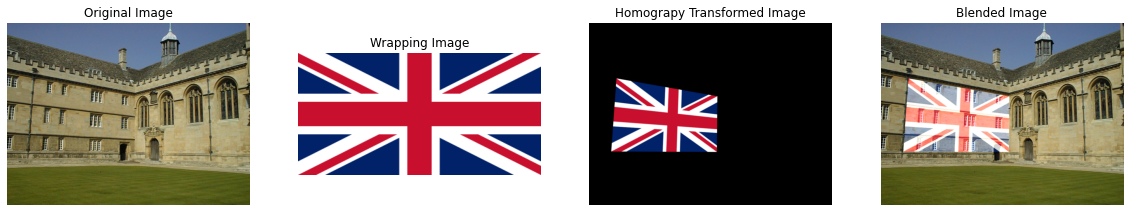

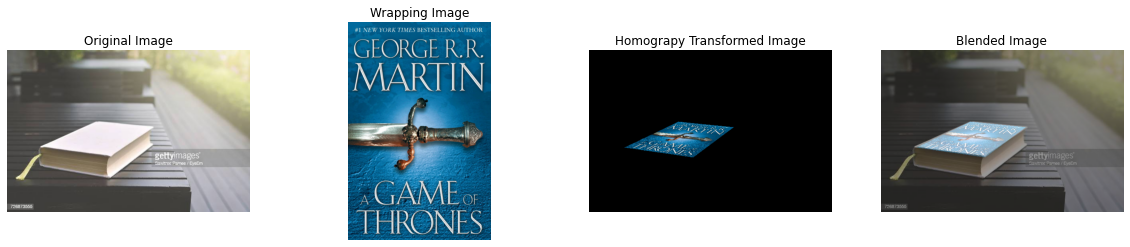

In [2]:
import numpy as np
import cv2 as cv
import matplotlib . pyplot as plt

def MouseHandling(event,x,y,f,pram):
    global im_temp,pts_src
    if event== cv.EVENT_LBUTTONDOWN:
        cv.circle(im_temp ,(x,y),3,(0,255,255),5,cv.LINE_AA)
        cv.imshow("Image",im_temp)
        if len(pts_src)<4:
            pts_src = np.append(pts_src,[(x,y)],axis=0)

architecture_img = cv.imread(r'Images/002.jpg')
flag = cv.imread(r'Images/Flag_of_the_United_Kingdom.png')
height , width = architecture_img.shape[0] , architecture_img.shape[1]
f_width,f_height = flag.shape[1] , flag.shape[0]
pts_dst = np.array([[0,0] , [f_width-1,0] , [f_width-1,f_height-1] , [0,f_height-1] ])
cv.namedWindow("Image",1)
ppp = cv.cvtColor(architecture_img, cv.COLOR_BGR2RGB)
im_temp = cv.cvtColor(ppp, cv.COLOR_RGB2BGR)
pts_src = np.empty((0,2))
cv.setMouseCallback("Image", MouseHandling)
cv.imshow("Image",im_temp)
cv.waitKey(0)

Homograpy_Matrix , status = cv.findHomography(pts_src, pts_dst)
transformed_flag = cv.warpPerspective(flag, np.linalg.inv(Homograpy_Matrix), (width, height))
blend_image = cv.addWeighted(architecture_img, 1, transformed_flag, 0.8, 0)

cv.imshow("Image",blend_image)
cv.waitKey(0)

figure, axes = plt.subplots(1,4, figsize=(20,4) )
axes[0].imshow(cv.cvtColor(architecture_img,cv.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[1].imshow(cv.cvtColor(flag,cv.COLOR_BGR2RGB))
axes[1].set_title("Wrapping Image")
axes[2].imshow(cv.cvtColor(transformed_flag,cv.COLOR_BGR2RGB))
axes[2].set_title("Homograpy Transformed Image")
axes[3].imshow(cv.cvtColor(blend_image,cv.COLOR_BGR2RGB))
axes[3].set_title("Blended Image")
for i in range(4):
    axes[i].axis("off")
cv.destroyAllWindows()

book_img = cv.imread(r'Images/book.jpg')
book_cover = cv.imread(r'Images/Game_of_thrones.webp')
height , width = book_img.shape[0] , book_img.shape[1]
b_width,b_height = book_cover.shape[1] , book_cover.shape[0]
pts_dst = np.array([[0,0] , [b_width-1,0] , [b_width-1,b_height-1] , [0,b_height-1] ])
cv.namedWindow("Image",1)
ppp = cv.cvtColor(book_img, cv.COLOR_BGR2RGB)
im_temp = cv.cvtColor(ppp, cv.COLOR_RGB2BGR)
pts_src = np.empty((0,2))
cv.setMouseCallback("Image", MouseHandling)
cv.imshow("Image",im_temp)
cv.waitKey(0)

Homograpy_Matrix , status = cv.findHomography(pts_src, pts_dst)
transformed = cv.warpPerspective(book_cover, np.linalg.inv(Homograpy_Matrix), (width, height))
blend_image = cv.addWeighted(book_img, 0.6, transformed, 0.5, 0)

cv.imshow("Image",blend_image)
cv.waitKey(0)

figure, axes = plt.subplots(1,4, figsize=(20,4) )
axes[0].imshow(cv.cvtColor(book_img,cv.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[1].imshow(cv.cvtColor(book_cover,cv.COLOR_BGR2RGB))
axes[1].set_title("Wrapping Image")
axes[2].imshow(cv.cvtColor(transformed,cv.COLOR_BGR2RGB))
axes[2].set_title("Homograpy Transformed Image")
axes[3].imshow(cv.cvtColor(blend_image,cv.COLOR_BGR2RGB))
axes[3].set_title("Blended Image")
for i in range(4):
    axes[i].axis("off")
cv.destroyAllWindows()

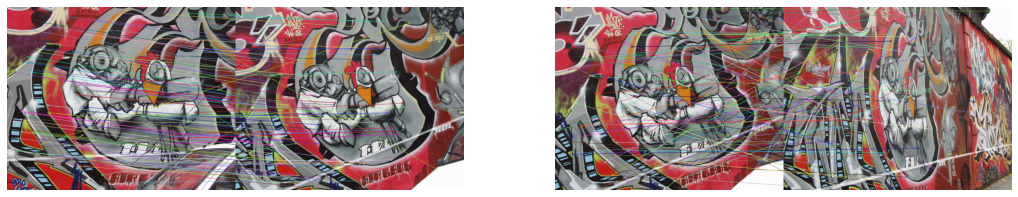

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

img1 = cv.imread(r"graf/img1.ppm", cv.IMREAD_COLOR)
img2 = cv.imread(r"graf/img2.ppm", cv.IMREAD_COLOR)
img3 = cv.imread(r"graf/img5.ppm", cv.IMREAD_COLOR)

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)


sift = cv.SIFT_create(nfeatures=0,nOctaveLayers=3,contrastThreshold=0.04,edgeThreshold=10,sigma=1.6)

kp1, descriptors_1 = sift.detectAndCompute(img1, None) 
kp2, descriptors_2 = sift.detectAndCompute(img2, None)
kp3, descriptors_3 = sift.detectAndCompute(img3, None)

bf1 = cv.BFMatcher(cv.NORM_L1, crossCheck = True)


matches1 = bf1.match(descriptors_1, descriptors_2)
matches2 = bf1.match(descriptors_2, descriptors_3)
sortmatches1 = sorted(matches1, key = lambda x:x.distance)
sortmatches2 = sorted(matches2, key = lambda x:x.distance)

img4 = cv.drawMatches(img1, kp1, img2, kp2, sortmatches1[:100], img2, flags =2)
img5 = cv.drawMatches(img2, kp2, img3, kp3, sortmatches2[:100], img3, flags = 2)

fig, ax = plt.subplots(1,2, figsize = (18, 18))
ax[0].imshow(img4)
ax[0].axis('off')
ax[1].imshow(img5)
ax[1].axis('off')
plt.show()